In [1]:
import os
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import timm
import clip
from tqdm.notebook import tqdm
from PIL import Image

# FACET + CLIP-Dissect

## CLIP-Dissect

In [2]:
# Read csv
df = pd.read_csv("../data/annotations/annotations.csv", index_col=0)
df = df.sort_values(by='filename')

unique_filenames = df['filename'].value_counts()
df = df[df['filename'].isin(unique_filenames[unique_filenames == 1].index)]
df.reset_index(inplace=True, drop=True)

filepaths = glob.glob("../data/imgs_*/*")
filenames = [i.split('/')[-1] for i in filepaths]
files = dict(zip(filenames, filepaths))
df['filepath'] = [files[i] for i in df['filename']]

In [3]:
# Device
if torch.mps.is_available():
    device = "mps" # mac m1/m2
elif torch.cuda.is_available():
    device = "cuda" # nvidia
else:
    device = "cpu"

# Terms/Concepts: for testing just using class labels for now
concepts = np.unique(df['class1'])
concepts = clip.tokenize(concepts).to(device)

# CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Mobilenet model
model = timm.create_model('mobilenetv3_large_100', pretrained=True)
model = model.to(device)

# Print stucture of mobilenet
#   see https://arxiv.org/pdf/1905.02244 for details
seen = set()
layer_groups = []
for k in model.state_dict().keys():
    group = k.split('.')[0]
    if group not in seen:
        seen.add(group)
        layer_groups.append(group)
print(layer_groups)

['conv_stem', 'bn1', 'blocks', 'conv_head', 'classifier']


In [4]:
# Track layer activation
#   any other intermediate layers can be added
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.conv_stem.register_forward_hook(get_activation('conv_stem'));
model.conv_head.register_forward_hook(get_activation('conv_head'));

In [5]:
n_rows = 100 # just using first 100 images for testing
P = np.zeros((n_rows, len(concepts)))
q_k_conv_head = np.zeros(n_rows)
q_k_conv_stem = np.zeros(n_rows)

for row in tqdm(range(n_rows), total=n_rows):

    # Load and preprocess image
    filepath = df['filepath'][row]
    img = Image.open(filepath)

    # Preprocess
    image = preprocess(img).unsqueeze(0).to(device)
    
    # 1. Compute P
    with torch.no_grad():
        logits_per_image, logits_per_text = clip_model(image, concepts)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    P[row] = probs

    # 2. Compute activations, q_k
    activation = {}
    _ = model(image)
    q_k_conv_head[row] = activation['conv_head'].squeeze().cpu().numpy().mean()
    q_k_conv_stem[row] = activation['conv_stem'].squeeze().cpu().numpy().mean()

  0%|          | 0/100 [00:00<?, ?it/s]

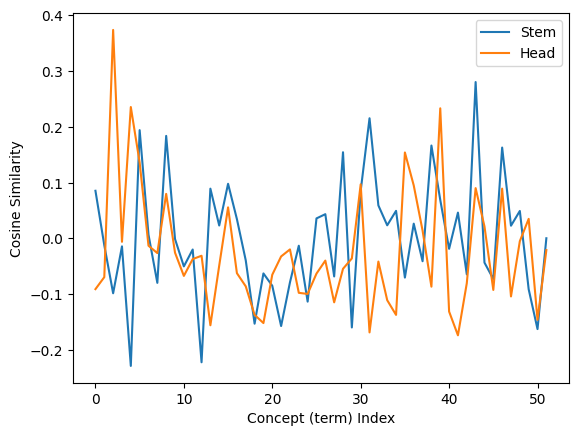

In [9]:
# 3. Compute similarity between P and q_k
def compute_cos_sim(P, q_k, demean=False):
    if demean:
        P = P - P.mean(axis=0)
        q_k = q_k - q_k.mean()
        
    P_norm = P / np.linalg.norm(P, ord=2, axis=0)
    q_k_norm = q_k / np.linalg.norm(q_k, ord=2)
    
    return P_norm.T @ q_k_norm

cos_sim_stem = compute_cos_sim(P, q_k_conv_stem, demean=True)
cos_sim_head = compute_cos_sim(P, q_k_conv_head, demean=True)

# Plot
plt.plot(cos_sim_stem, label='Stem')
plt.plot(cos_sim_head, label='Head')
plt.ylabel("Cosine Similarity")
plt.xlabel("Concept (term) Index")
plt.legend();